# Gather Resources
To begin, we must have three important resources with the following instructions:
1. Download the Human Phenotype Ontology (hpo) in json format by going to hpo.jax.org/app/data/ontology and selecting "DOWNLOAD LATEST HP.JSON".
2. Download the hpo annotation file which contains disease annotations by going to hpo.jax.org/app/data/annotations and selecting "DOWNLOAD HPO ANNOTATIONS".
3. Clone the git repository hosted at https://github.com/monarch-initiative/phenopacket-store to your local machine. We will be using the folder phenopacket-store/notebooks in this tutorial as a resource of phenopackets of real individuals.

In [1]:
# Record paths for resouces collected above
fpath_hpo: str = '/home/bcoleman/Projects/human-phenotype-ontology/src/ontology/hp.json' # path for hpo.json file
fpath_phenopackets = '/home/bcoleman/Projects/phenopacket-store/notebooks' # path for phenopackets-store notebooks
fpath_hpoa = '/home/bcoleman/Downloads/phenotype.hpoa' # path for hpo phenotype.hpoa file

# Declare Variables

In [2]:
# Choose similarity algorithms
methods = ['phenomizer', 'count', 'simici', 'phrank', 'jaccard', 'simgic', 'simgci']

# P-value based similarities use artificial individuals to make a null distribution to calculate p-values.
# Similarities of real individuals are compared to those of artificial individuals with the same number of features.
# Choose the maximum number of features for artificial individuals and the number of artificial individuals to use.
# By setting null_dist_samples to 0, we will not calculate p-value similarities.
# Hint: Increasing these settings will greatly increase runtime.
num_features = 30 # number of features for artifical null distribution patients 
null_dist_samples = 1000 # number of individuals in null distribution

# Choose the number of cpus to use.
num_cpus = 6


# Load Resource Data

In [3]:
from hpotk.ontology.load.obographs import load_minimal_ontology
from hpotk.ontology import MinimalOntology
from sumsim.io import read_folder, read_hpoa
import warnings

# Import hpo.json file
hpo: MinimalOntology = load_minimal_ontology(fpath_hpo)

# Import samples. Recursive import finds phenopackets in subfolders.
# read_folder and read_hpoa will generate warnings from phenopackets with redundant terms (ancestors of other included terms)
# and terms that cannot be read. We will filter warnings for this step to silence these.
warnings.filterwarnings('ignore')
samples = read_folder(fpath_phenopackets, hpo, recursive = True)

# Samples with no features should always have a similarity of 0. We will remove them to avoid problems.
samples = [sample for sample in samples if len(sample.phenotypic_features) > 0]

# Import diseases in a similar format to samples (individuals).
diseases = read_hpoa(fpath_hpoa, hpo)

# Turn warnings back to default
warnings.filterwarnings('default')

# Calculate Term Information Content (IC)

In [4]:
from sumsim.sim import IcCalculator, IcTransformer

# The IcCalculator class object will be used to create a dictionary with term ids and ic values.
# IC values are calculated as the base 10 log of the number of diseases divided by the number of diseases annotated with that term.
# Diseases are annotated with a term when the disease is annotated with that term or any of its descendants.
calc = IcCalculator(hpo, multiprocess=True, progress_bar=True)
ic_dict = calc.calculate_ic_from_diseases(diseases) # alternatively "calculate_ic_from_samples" can be used to calculate ic using feature 
                                                    # prevalence in samples.

# The IcTransformer calculates the  conditional information for each term given its parents.
# We only need to supply diseases if we are using the method, phrank, which requires additional information to approximate conditional information.
transformer = IcTransformer(hpo, samples=diseases)
delta_ic_dict = transformer.transform(ic_dict)
bayes_ic_dict = transformer.transform(ic_dict, strategy="bayesian") # Used for phrank

# Create "Noisy" Patients with common terms added (optional)

In [5]:
import math
import random
from statistics import mean
from sumsim.model import Sample

common_terms = [term for term in ic_dict.keys() if ic_dict[term] <= math.log(10)]
noisy_samples = []
for sample in samples:
    noisy_features = list(sample.phenotypic_features) + list(random.sample(common_terms, 20))
    noisy_label = sample.label + "noisy"
    noisy_samples.append(
        Sample(label=noisy_label, phenotypic_features=noisy_features, disease_identifier=sample.disease_identifier,
               hpo=hpo))

print(f"There are {len(common_terms)} common terms with IC equal to or less than ln(10) ({math.log(10)}).")
print(f'The samples have an average of {mean([len(sample.phenotypic_features) for sample in samples])} terms after removing ancestors and duplicates.')
print(f'The noisy samples (with 20 random common terms added) have an average of {mean([len(sample.phenotypic_features) for sample in noisy_samples])} terms after removing ancestors and duplicates.')

samples = samples + noisy_samples

There are 142 common terms with IC equal to or less than ln(10) (2.302585092994046).
The samples have an average of 8.625694671461261 terms after removing ancestors and duplicates.
The noisy samples (with 20 random common terms added) have an average of 22.298790454396862 terms after removing ancestors and duplicates.


# Only use diseases in samples (optional)
For testing, consider only using diseases that are listed as a diagnosis in samples of interest to reduce runtime.

In [6]:
used_diseases = set(sample.disease_identifier.identifier.value for sample in samples)
diseases = [disease for disease in diseases if disease.identifier.value in used_diseases]
print(f'Number of unique diagnoses: {len(used_diseases)}\nNumber of overlapping diseases: {len(diseases)}')

Number of unique diagnoses: 343
Number of overlapping diseases: 317


# Calculate similarities between diseases and samples

In [7]:
from sumsim.matrix import SimilarityMatrix
# Run Sim Matrix
sim_matrix = SimilarityMatrix(hpo=hpo,
                              chunksize=1, # Chunksize refers to the number of diseases per "chunk". 
                                           # Smaller chunksizes are often optimal because diseases with more features take longer to run.
                              delta_ic_dict=delta_ic_dict, # Used for simici and simgci
                              ic_dict=ic_dict, # Used for phenomizer and simgic
                              bayes_ic_dict=bayes_ic_dict, # Used for phrank
                              n_iter_distribution=null_dist_samples,
                              num_cpus=num_cpus,
                              num_features_distribution=num_features,
                              patients=samples,
                              similarity_methods=methods,
                              multiprocess=True
                              )
results = sim_matrix.compute_diagnostic_similarities(diseases)

There are 16 CPUs available for multiprocessing. Using 6 CPUs.


Diseases: 100%|███████████████████████████████| 317/317 [14:40<00:00,  2.78s/it]


# Find rank of correct diagnosis

In [8]:
from sumsim.matrix import Rank


rank = Rank(results)
rank.rank()

# Rank.get_gaphable returns a pandas dataframe that can easily be used with seaborn for visualization.
# Samples with more features than max_term_num will be removed.
# The suffix_variable is the string we appended to the sample names earlier. It is used to separate out the "noisy" samples.
rankings = rank.get_graphable(suffix_variable="noisy", max_term_num=30)

Removing 1398  patients with a diagnosis not in the matrix.
Keeping 4720 patients.
There are 26 missing diagnoses.

Removing 195 patients with more than 30 terms.
Keeping 4525 patients.



/home/bcoleman/Projects/sumsim/src/sumsim/matrix/_rank.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphable["Test"].loc[graphable[suffix_variable]] = [f"{test} & {suffix_variable}" for test in


# Graph Results

[Text(0, 0.5, 'rank')]

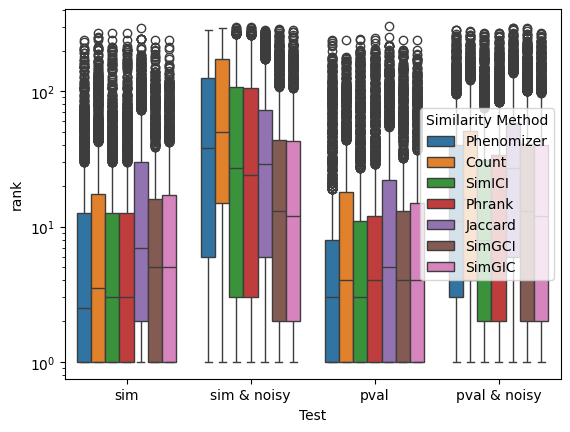

In [9]:
import seaborn as sns
g = sns.boxplot(data=rankings, x = "Test", y='Rank', hue='Similarity Method',  hue_order=["Phenomizer", "Count", "SimICI", "Phrank", "Jaccard", "SimGCI", "SimGIC"])
g.set_yscale('log')
g.set(ylabel='rank')

# Save Results

In [10]:
# Record paths for data exports
export_result_name = f'benchmark_results_m_{methods}_ndist_{null_dist_samples}_nfeatures_{num_features}.csv'
export_rank_name = f'benchmark_rankings_m_{methods}_ndist_{null_dist_samples}_nfeatures_{num_features}.csv'

# It is recommended that both results and rankings be saved
results.to_csv(export_result_name)
rankings.to_csv(export_rank_name)